# Accessing model data

We'll use tools from xmip and xarray to clean up the datasets and to compute weighted averages.

In [20]:
# lets start by loading a few example dataset
from xmip.utils import google_cmip_col
import xmip.preprocessing as xp
import intake 
import xarray as xr
import numpy as np
import pandas as pd

col = google_cmip_col()

## Check the variables to make sure all are present.

In [2]:
col_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(col_url)

query_simon = col.search(
    experiment_id="historical",
    table_id="SImon",
    variable_id=["sispeed", "siconc"]
)
df_simon = query_simon.df

query_ofx = col.search(
    experiment_id="historical",
    table_id="Ofx",
    variable_id=["areacello"]
)
df_ofx = query_ofx.df

In [3]:
n_ensembles = df_simon.loc[df_simon.variable_id=='sispeed'].groupby('source_id').count()['member_id']
df_filtered = df_simon.groupby('source_id').filter(lambda x: x.name in n_ensembles.index)
df_filtered.loc[df_filtered.variable_id == 'sispeed'].groupby('source_id').count()

,activity_id,institution_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
source_id,,,,,,,,,,
ACCESS-CM2,3,3,3,3,3,3,3,3,0,3
ACCESS-ESM1-5,7,7,7,7,7,7,7,7,0,7
AWI-CM-1-1-MR,5,5,5,5,5,5,5,5,0,5
AWI-ESM-1-1-LR,1,1,1,1,1,1,1,1,0,1
CESM2,10,10,10,10,10,10,10,10,0,10
CESM2-FV2,3,3,3,3,3,3,3,3,0,3
CESM2-WACCM,3,3,3,3,3,3,3,3,0,3
CESM2-WACCM-FV2,3,3,3,3,3,3,3,3,0,3
CIESM,3,3,3,3,3,3,3,3,0,3


In [60]:
# XMIP has lots of tools that can make CMIP6
# analysis easier. Not all are appropriate for
# every grid, though -- I ran into some errors 
# trying to use their "correct_lon" function.
def wrapper(ds):
    ds = ds.copy()
    ds = xp.rename_cmip6(ds)
    ds = xp.promote_empty_dims(ds)
    ds = xp.broadcast_lonlat(ds)
    # ds = xp.replace_x_y_nominal_lat_lon(ds)
    # ds = xp.correct_lon(ds)
    # ds = xp.correct_coordinates(ds)
    # ds = xp.parse_lon_lat_bounds(ds)
    return ds

source_id = 'IPSL-CM6A-LR'

# Example for CESM2
cat_data = col.search(
    experiment_id='historical',
    source_id=source_id,
    grid_label='gn',
    table_id='SImon',
    variable_id=['sispeed', 'siconc']
)

query_ofx = col.search(
    source_id=source_id,
    grid_label='gn',
    experiment_id='historical',
    table_id='Ofx',
    variable_id=['areacello']
)

In [61]:
ddict_area = query_ofx.to_dataset_dict(aggregate=False, preprocess=wrapper)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [62]:
ddict = cat_data.to_dataset_dict(aggregate=False, preprocess=wrapper)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [63]:
# Build a lookup table to keep track of variables
name_lookup = {}
for x in ddict.keys():
    info = x.split('.')
    ens = info[4]
    var = info[6]
    if ens not in name_lookup:
        name_lookup[ens] = {}
    name_lookup[ens][var] = x

for x in ddict_area.keys():
    info = x.split('.')
    ens = info[4]
    var = info[6]
    if ens in name_lookup:
        name_lookup[ens][var] = x

In [64]:
for ens in name_lookup:
    print(ens, name_lookup[ens].keys())

r5i1p1f1 dict_keys(['sispeed', 'siconc', 'areacello'])
r13i1p1f1 dict_keys(['sispeed', 'siconc', 'areacello'])
r19i1p1f1 dict_keys(['siconc', 'sispeed', 'areacello'])
r32i1p1f1 dict_keys(['siconc', 'areacello'])
r24i1p1f1 dict_keys(['siconc', 'areacello'])
r17i1p1f1 dict_keys(['siconc', 'areacello'])
r9i1p1f1 dict_keys(['sispeed', 'siconc', 'areacello'])
r3i1p1f1 dict_keys(['sispeed', 'siconc', 'areacello'])
r12i1p1f1 dict_keys(['sispeed', 'siconc', 'areacello'])
r1i1p1f1 dict_keys(['sispeed', 'siconc', 'areacello'])
r4i1p1f1 dict_keys(['siconc', 'sispeed', 'areacello'])
r15i1p1f1 dict_keys(['siconc', 'areacello'])
r18i1p1f1 dict_keys(['siconc', 'areacello'])
r11i1p1f1 dict_keys(['siconc', 'sispeed', 'areacello'])
r16i1p1f1 dict_keys(['siconc', 'areacello'])
r22i1p1f1 dict_keys(['siconc', 'areacello'])
r23i1p1f1 dict_keys(['siconc', 'areacello'])
r14i1p1f1 dict_keys(['siconc', 'sispeed', 'areacello'])
r28i1p1f1 dict_keys(['siconc', 'areacello'])
r31i1p1f1 dict_keys(['siconc', 'areacell

# Some notes
* CMCC-ESM2 sea ice speed as dimensions 291x360, while the ocean grid has 292by362, so extra steps are needed.
* I'm getting higher drift speed mean values than Wang et al. for some models -- what differences in methods might account for that?
* 

In [65]:
min_lat = 50
results_speed = {}
results_area = {}
for ens in name_lookup: # loop through ensemble members
    if np.all([v in name_lookup[ens].keys() for v in ['sispeed', 'siconc', 'areacello']]):
        ds_sispeed = ddict[name_lookup[ens]['sispeed']]
        ds_siconc = ddict[name_lookup[ens]['siconc']]
        ds_area = ddict_area[name_lookup[ens]['areacello']]
        
        # Pulling the datasets into a single dataframe can sometimes make things easier
        # In the case of CESM2, the issue is that the sea ice model grid has masked 
        # latitude longitude cells, so you can't easily do selections or plotting.
        # Luckily the areacello dataset has non-masked lat/lon fields.
        ds = xr.Dataset({'sispeed': (('time', 'y', 'x'), ds_sispeed['sispeed'].squeeze().data),
                         'siconc': (('time', 'y', 'x'), ds_siconc['siconc'].squeeze().data),
                         'area': (('y', 'x'), ds_area['areacello'].squeeze().data),
                         'latitude': (('y', 'x'), ds_area.lat.data),
                         'longitude': (('y', 'x'), ds_area.lon.data)
                        },
                   coords={'time': ('time', ds_sispeed.time.data),
                           'y': (('y'), ds_area.y.data),
                           'x': (('x'), ds_area.x.data)
                         })

        
        # area weights need to be set to zero outside the sea ice region
        ds_sel = ds.sel(time=slice('1979-01-01', '2014-12-31'))

        # Using "where" on the siconc variable broadcasts the 2d area
        # dataset into a 3d one (x, y, time). We also need to replace
        # NaN's with a weight of 0
        a = ds_sel['area'].where((ds_sel['siconc'] > 15) &
                (ds_sel['latitude'] > min_lat)).fillna(0)

        # We can then use the built-in "weighted" function 
        # with our 0-masked area grid
        sispeed_mean = ds_sel['sispeed'].where(
            ds_sel['siconc'] > 15).where(
            ds_sel['latitude'] > min_lat).weighted(
            a).mean(['x','y']).squeeze().compute()

        # Finally we store the results in a dictionary
        results_speed[ens] = sispeed_mean.to_pandas()
        results_area[ens] = a.sum(['x', 'y']).compute().to_pandas()
        print(ens)
        

r5i1p1f1
r13i1p1f1
r19i1p1f1
r9i1p1f1
r3i1p1f1
r12i1p1f1
r1i1p1f1
r4i1p1f1
r11i1p1f1
r14i1p1f1
r29i1p1f1
r6i1p1f1
r26i1p1f1
r2i1p1f1
r7i1p1f1


In [66]:
# Save results to CSV

pd.DataFrame(results_speed).to_csv('sispeed_csv/' + 'cmip6.historical.' + source_id + '.sispeed.area_mean.csv')
pd.DataFrame(results_area).to_csv('siarea_csv/' + 'cmip6.historical.' + source_id + '.siarea.csv')

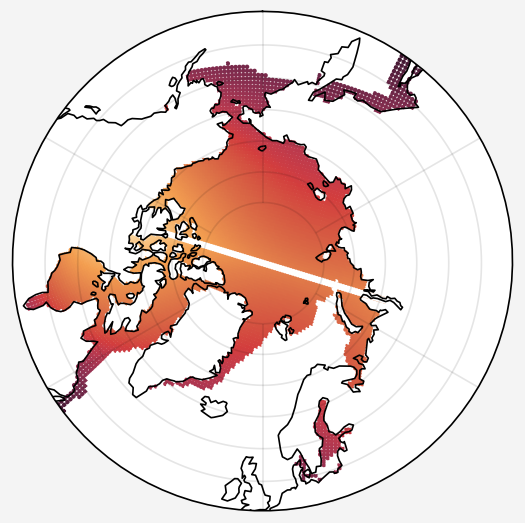

In [74]:
# Quick check to see if the area is getting masked reasonably
import proplot as pplt
import warnings
warnings.simplefilter('ignore')

A = ds_sel['area'].where((ds_sel['siconc'] > 15) &
                (ds_sel['latitude'] > min_lat)).fillna(0).compute()
fig, ax = pplt.subplots(proj='npstere')
ax.format(boundinglat=50, coast=True)
lt = np.ravel(ds['latitude'].data)
ln = np.ravel(ds['longitude'].data)
a = np.ravel(A.isel(time=0))
ax.scatter(ln, lt, c=a, ms=1)

In [75]:
test = ds_sispeed['sispeed'].where(ds_sispeed['lat'] > 55).compute().mean(['x', 'y'])

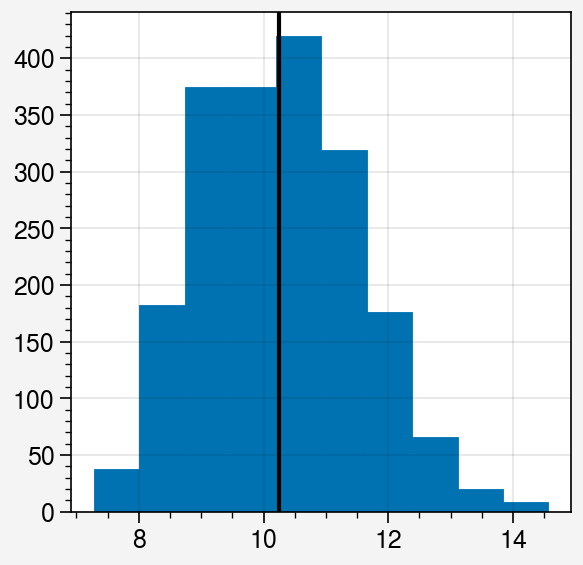

In [76]:
# Distribution of monthly mean drift speeds above 55 degrees latitude
fig, ax = pplt.subplots()
ax.hist(test.to_numpy().squeeze()*24*60*60/1000)
ax.axvline((test.to_numpy().squeeze()*24*60*60/1000).mean(), color='k')

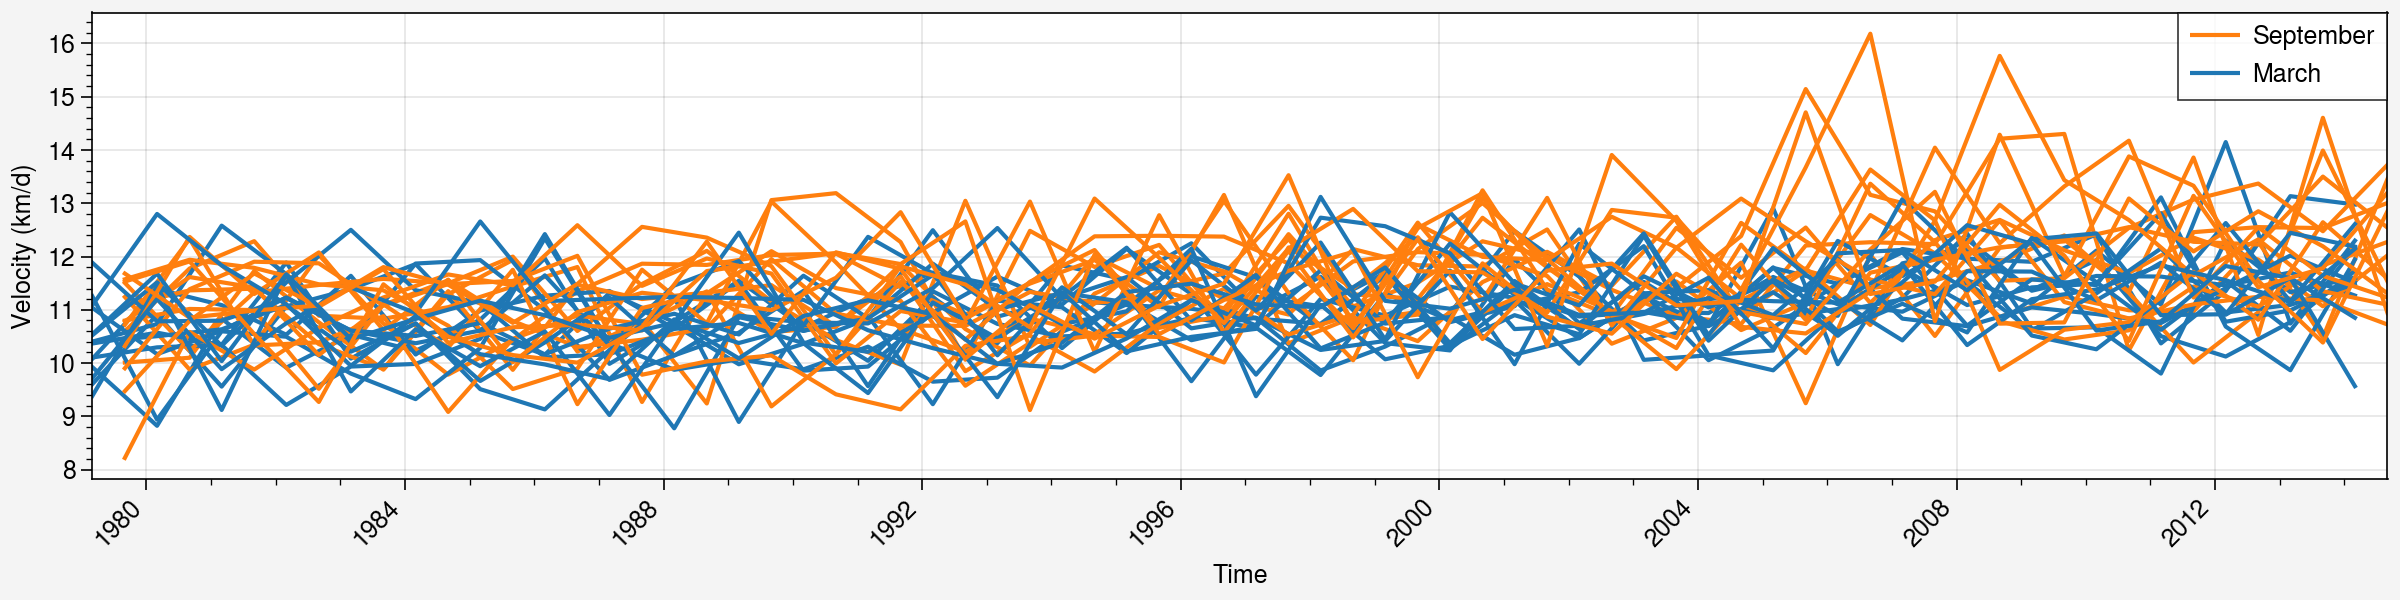

In [77]:
fig, ax = pplt.subplots(width=12, height=3)
for ens in results_speed:
    a = results_speed[ens]
    a = a.loc[a.index.month==3]
    t = pd.to_datetime({'year': a.index.year,
                'month': a.index.month,
                'day': 1})
    ax.plot(t, a * (24 * 60 * 60)/1000, color='tab:blue')

    a = results_speed[ens]
    a = a.loc[a.index.month==9]
    t = pd.to_datetime({'year': a.index.year,
                'month': a.index.month,
                'day': 1})
    ax.plot(t, a * (24 * 60 * 60)/1000, color='tab:orange')

# Some formatting and legend creation
h = [ax.plot([],[],color='tab:orange'), ax.plot([], [], color='tab:blue')]
ax.legend(h, ['September', 'March'], ncols=1)
ax.format(xlabel='Time', xrotation=45, ylabel='Velocity (km/d)')

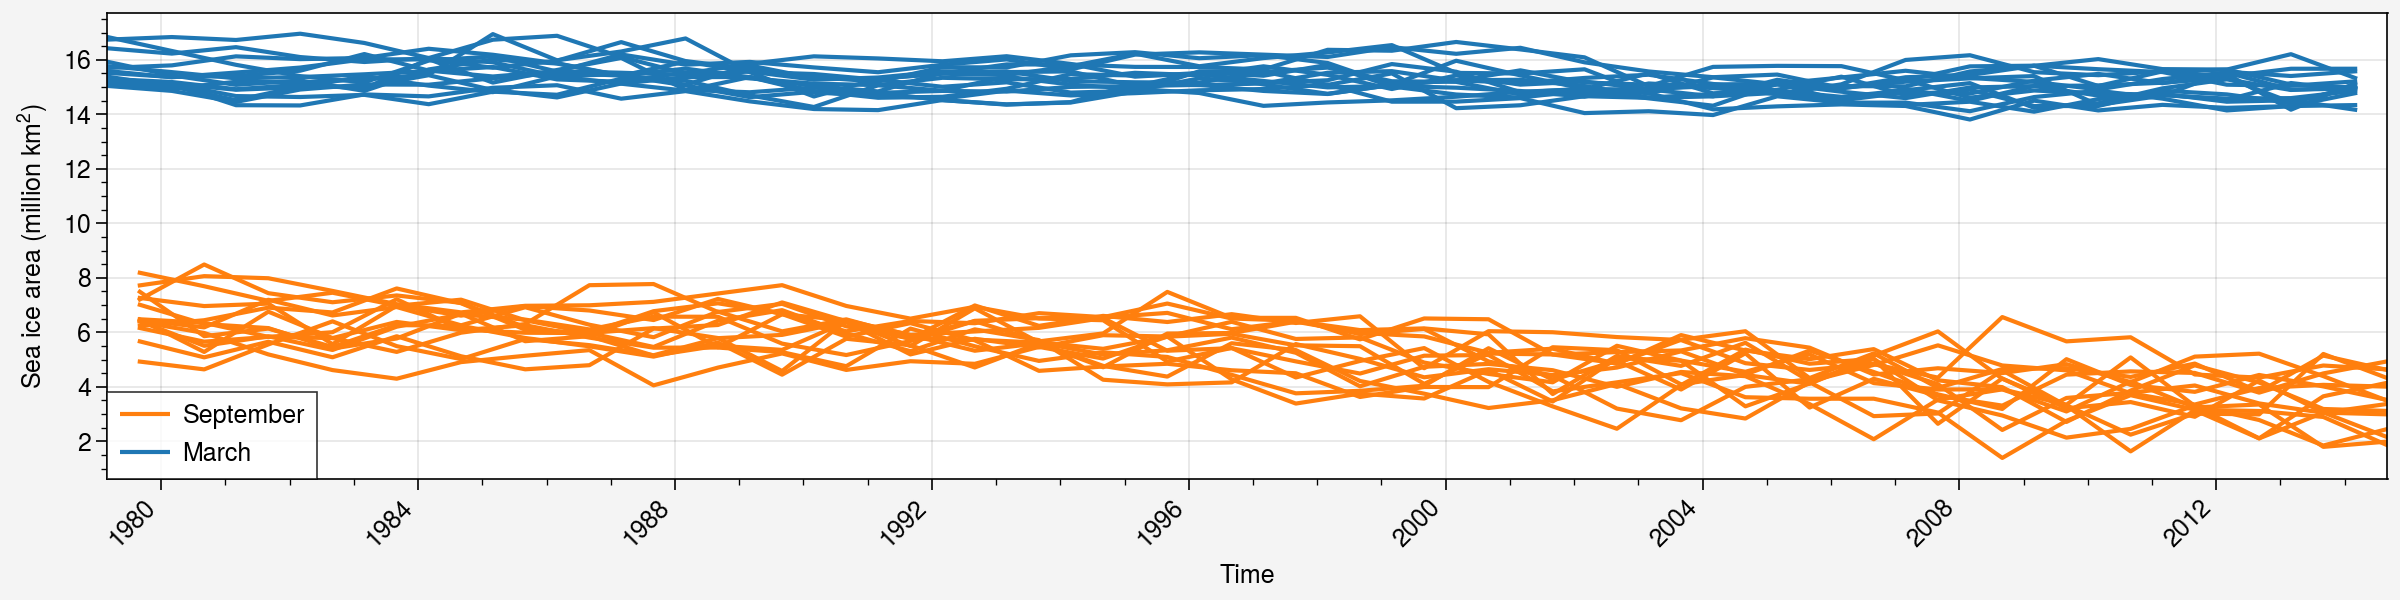

In [78]:
fig, ax = pplt.subplots(width=12, height=3)
for ens in results_area:
    a = results_area[ens]
    a = a.loc[a.index.month==3]
    t = pd.to_datetime({'year': a.index.year,
                'month': a.index.month,
                'day': 1})
    ax.plot(t, a/1e12, color='tab:blue')

    a = results_area[ens]
    a = a.loc[a.index.month==9]
    t = pd.to_datetime({'year': a.index.year,
                'month': a.index.month,
                'day': 1})
    ax.plot(t, a/1e12, color='tab:orange')
# Some formatting and legend creation
h = [ax.plot([],[],color='tab:orange'), ax.plot([], [], color='tab:blue')]
ax.legend(h, ['September', 'March'], ncols=1)
ax.format(xlabel='Time', xrotation=45, ylabel='Sea ice area (million km$^2$)')

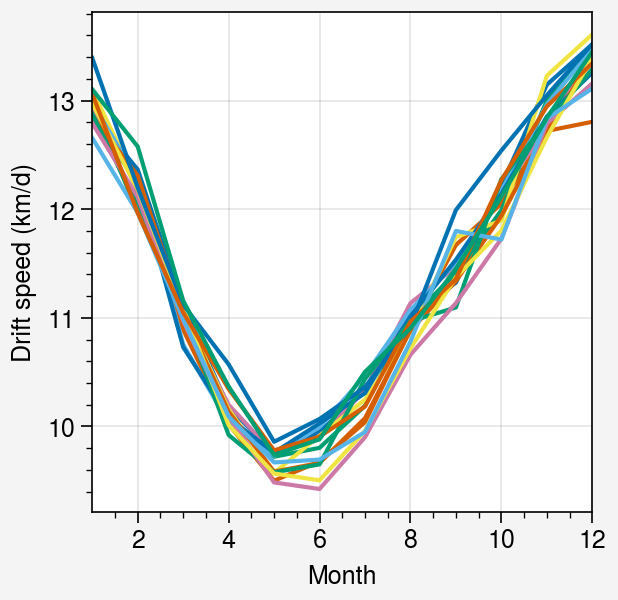

In [79]:
# m/s * (1 km / 1000 m) * (24 * 60 * 60 s / 1 day) = km/d
import proplot as pplt
sispeed = pd.DataFrame(results_speed)
fig, ax = pplt.subplots()
ax.plot(sispeed.groupby(sispeed.index.month).mean()*24*60*60/1000)
ax.format(ylabel='Drift speed (km/d)', xlabel='Month')

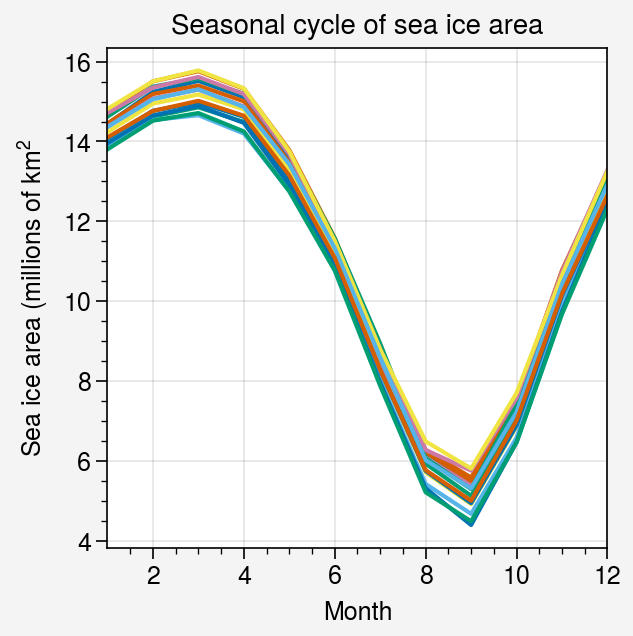

In [80]:
# m/s * (1 km / 1000 m) * (24 * 60 * 60 s / 1 day) = km/d
import proplot as pplt
siarea = pd.DataFrame(results_area)
fig, ax = pplt.subplots()
ax.plot(siarea.groupby(siarea.index.month).mean()/(1e12))
ax.format(ylabel='Sea ice area (millions of km$^2$', xlabel='Month', title='Seasonal cycle of sea ice area')